In [36]:
%%capture
!pip install gymnasium

# Environment for Modified Travelling Salesman Problem


In [37]:
from typing import Dict, List, Optional, Tuple
import gymnasium as gym
import numpy as np
from numpy import typing as npt
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

In [38]:

class ModTSP(gym.Env):
    """Travelling Salesman Problem (TSP) RL environment for maximizing profits.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets so maximize profits. The profits decay with time.
    """

    def __init__(
        self,
        num_targets: int = 10,
        max_area: int = 15,
        shuffle_time: int = 10,
        seed: int = 42,
    ) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): No. of targets the agent needs to visit.
            max_area (int): Max. Square area where the targets are defined.
            shuffle_time (int): No. of episodes after which the profits ar to be shuffled.
            seed (int): Random seed for reproducibility.
        """
        super().__init__()

        np.random.seed(seed)

        self.steps: int = 0
        self.episodes: int = 0

        self.shuffle_time: int = shuffle_time
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: npt.NDArray[np.float32] = self._generate_points(self.num_targets)
        self.distances: npt.NDArray[np.float32] = self._calculate_distances(self.locations)

        # Initialize profits for each target
        self.initial_profits: npt.NDArray[np.float32] = np.arange(1, self.num_targets + 1, dtype=np.float32) * 10.0
        self.current_profits: npt.NDArray[np.float32] = self.initial_profits.copy()

        # Observation Space : {current loc (loc), target flag - visited or not, current profits, dist_array (distances), coordintates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),  # Current location
                np.zeros(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                np.zeros(self.num_targets, dtype=np.float32),  # Array of all current profits values
                np.zeros(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                np.zeros(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),  # Current location
                np.ones(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                100 * np.ones(self.num_targets, dtype=np.float32),  # Array of all current profits values
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )

        # Action Space : {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0
        self.episodes += 1

        self.loc: int = 0
        self.visited_targets: npt.NDArray[np.float32] = np.zeros(self.num_targets)
        self.current_profits = self.initial_profits.copy()
        self.dist: List = self.distances[self.loc]

        if self.shuffle_time % self.episodes == 0:
            np.random.shuffle(self.initial_profits)

        state = np.concatenate(
            (
                np.array([self.loc]),
                self.visited_targets,
                self.initial_profits,
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        self.current_profits -= self.distances[past_loc, next_loc]
        reward = self._get_rewards(next_loc)

        self.visited_targets[next_loc] = 1

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                self.visited_targets,
                self.current_profits,
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> npt.NDArray[np.float32]:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        return np.random.uniform(low=0, high=self.max_area, size=(num_points, 2)).astype(np.float32)

    def _calculate_distances(self, locations: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        """Calculate the distance matrix between all target locations.

        Args:
            locations: List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        reward = self.current_profits[next_loc] if not self.visited_targets[next_loc] else -1e4
        return float(reward)




# Q-Learning Algorithm

In [39]:
class QAgent:
    def __init__(self, num_actions, learning_rate=0.1, discount_factor=0.99):
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.q_values = {}  # Store the Q-values for state-action pairs
        self.error_log = []  # Track TD errors

    def select_action(self, current_state):
        """Select the action with the highest Q-value for a given state."""
        state_key = self._state_to_str(current_state)
        if state_key not in self.q_values:
            # Initialize Q-values for new states
            self.q_values[state_key] = np.zeros(self.num_actions)
        # Choose the action with the maximum Q-value
        return np.argmax(self.q_values[state_key])

    def update_q(self, state, action, reward, next_state):
        """Perform the Q-learning update step."""
        state_key = self._state_to_str(state)
        next_state_key = self._state_to_str(next_state)

        # Initialize Q-values for unseen next states
        if next_state_key not in self.q_values:
            self.q_values[next_state_key] = np.zeros(self.num_actions)

        # Calculate the TD target and error
        next_best_action = np.argmax(self.q_values[next_state_key])
        target = reward + self.discount_factor * self.q_values[next_state_key][next_best_action]
        td_error = target - self.q_values[state_key][action]

        # Track the TD error
        self.error_log.append(abs(td_error))

        # Update the Q-value
        self.q_values[state_key][action] += self.learning_rate * td_error

    def _state_to_str(self, state):
        """Convert the state array to a string key for the Q-value dictionary."""
        return str(state)


In [40]:
def moving_average(data, window_size):
    """Calculate the moving average of a given data sequence."""
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

In [41]:
def run_episodes(num_episodes, targets, shuffle_interval):
    """Run Q-learning agent for the specified number of episodes."""
    # Initialize the environment and Q-learning agent
    environment = ModTSP(targets, shuffle_time=shuffle_interval)
    agent = QAgent(num_actions=targets)

    rewards_per_episode = []  # Track of rewards for each episode
    error_means = []  # Average TD error for each episode
    final_path = []  # Store the final path (sequence of target locations)

    for episode in range(num_episodes):
        state, _ = environment.reset()
        episode_done = False
        accumulated_reward = 0
        path = []  # Track the path for each episode

        while not episode_done:
            current_location = state[0]
            path.append(current_location)  # Record the current location

            # Select action, step in environment, and update Q-values
            chosen_action = agent.select_action(state)
            new_state, reward, terminated, truncated, _ = environment.step(chosen_action)
            episode_done = terminated or truncated

            agent.update_q(state, chosen_action, reward, new_state)

            # Accumulate rewards
            accumulated_reward += reward
            state = new_state

        # Log results after the episode ends
        rewards_per_episode.append(accumulated_reward)
        error_means.append(np.mean(agent.error_log))

        # Update final path if it's the last episode
        if episode == num_episodes - 1:
            final_path = path

        # Optionally print episode rewards
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1} / {num_episodes}: Reward: {accumulated_reward}")

    # Return collected rewards, errors, and the final path for plotting later
    return rewards_per_episode, error_means, final_path, environment.locations

In [42]:
def plot_rewards(rewards_per_episode, num_episodes, window_size=100):
    """Plot cumulative rewards and smoothed rewards."""
    # Calculate smoothed rewards using a moving average
    smoothed_rewards = moving_average(rewards_per_episode, window_size)

    # Adjust the x-axis for the smoothed data (since moving average reduces the number of points)
    smoothed_episodes = range(window_size - 1, num_episodes)

    # Plot cumulative rewards and smoothed rewards
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_episodes), rewards_per_episode, label="Cumulative Reward", alpha=0.5)
    plt.plot(smoothed_episodes, smoothed_rewards, label=f"Smoothed Reward (window={window_size})", color='g', linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.title("Episode vs Cumulative Reward (Training Convergence)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [43]:
def plot_final_path(path, locations):
    """Plot the final path the agent took through all the targets, with arrows, indices, and coordinates."""
    plt.figure(figsize=(8, 8))

    # Plot the locations of all targets
    x_coords, y_coords = locations[:, 0], locations[:, 1]
    plt.scatter(x_coords, y_coords, c='blue', label='Targets')

    # Annotate the target indices and coordinates
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        plt.text(x, y, f"({i + 1}) ({x:.1f}, {y:.1f})", fontsize=9, ha='right', color='red')

    # Plot the path taken by the agent
    path = np.array(path).astype(int)  # Convert the path to integer indices
    path_x = x_coords[path]
    path_y = y_coords[path]
    plt.plot(path_x, path_y, c='green', label='Agent Path', marker='o')

    # Draw arrows for the direction of the path
    for i in range(len(path_x) - 1):
        arrow = FancyArrowPatch((path_x[i], path_y[i]), (path_x[i + 1], path_y[i + 1]),
                                arrowstyle='->', color='black', mutation_scale=15)
        plt.gca().add_patch(arrow)

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Agent's Final Path Through All Targets")
    plt.legend()
    plt.grid(True)
    plt.show()

In [45]:
def main():
    """Run the Q-learning agent, plot rewards and final path."""
    num_episodes = 999
    targets = 10
    shuffle_interval = 50
    # Run episodes and collect rewards, final path, and target locations
    rewards, errors, final_path, target_locations = run_episodes(num_episodes=num_episodes, targets=targets, shuffle_interval=shuffle_interval)
    # Print average reward over all episodes
    print(f"Average reward over {num_episodes} episodes: {np.mean(rewards)}")
    # Plot the rewards separately
    plot_rewards(rewards, num_episodes=num_episodes, window_size=100)
    # Plot the final path taken by the agent with coordinates and arrows
    plot_final_path(final_path, target_locations)

Episode 100 / 999: Reward: -9845.449884414673
Episode 200 / 999: Reward: -9779.492130279541
Episode 300 / 999: Reward: 138.24699878692627
Episode 400 / 999: Reward: 145.5390100479126
Episode 500 / 999: Reward: 133.38324451446533
Episode 600 / 999: Reward: 159.56847667694092
Episode 700 / 999: Reward: 159.56847667694092
Episode 800 / 999: Reward: 159.56847667694092
Episode 900 / 999: Reward: 159.56847667694092
Average reward over 999 episodes: -6299.186872356288


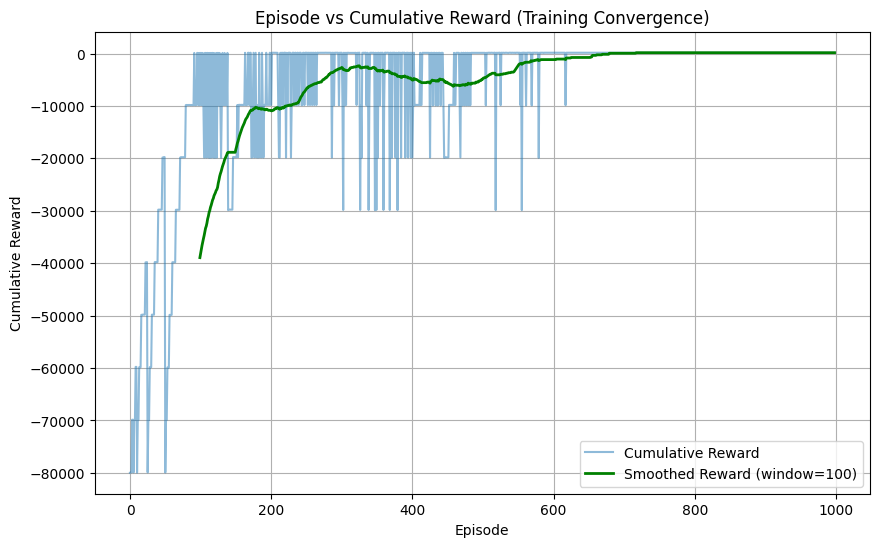

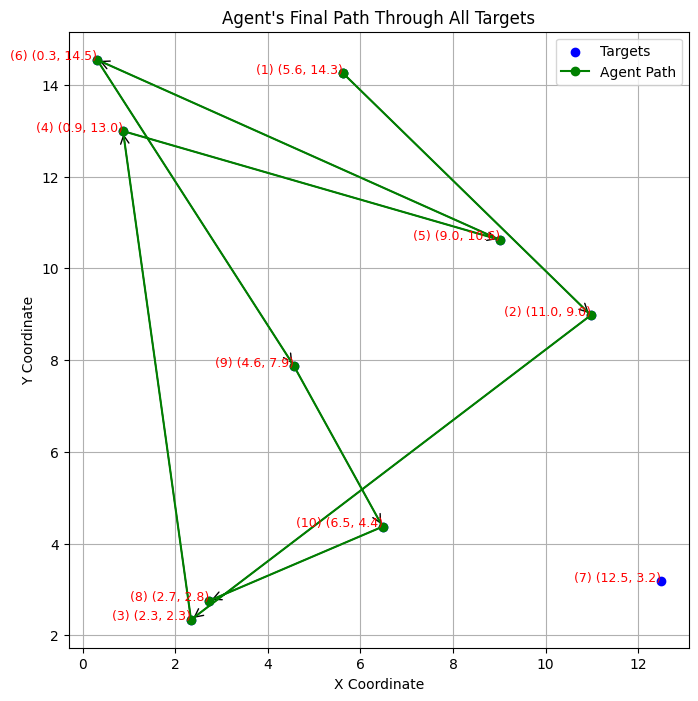

In [46]:
if __name__ == "__main__":
    main()